In [64]:
!pip install opendatasets --upgrade

You should consider upgrading via the 'C:\Users\Naveen\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [65]:
import opendatasets as od

# Importing Libraries

In [68]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import os
import time
import random 
import shutil
import math
import torch
import pandas as pd
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchvision.utils import make_grid
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

print("using Pytorch version", torch.__version__)


using Pytorch version 1.10.1+cpu


In [69]:
ls

 Volume in drive C is Windows
 Volume Serial Number is B8C0-2582

 Directory of C:\Users\Naveen\Downloads

11-01-2022  20:54    <DIR>          .
11-01-2022  20:48    <DIR>          ..
11-01-2022  20:26    <DIR>          .ipynb_checkpoints
13-12-2021  10:30       192,467,033 09.mkv
08-12-2021  18:09               132 2021_12_08180829output.csv
08-12-2021  22:15               121 2021_12_08221525output.csv
09-12-2021  09:14               121 2021_12_09091407output.csv
10-12-2021  19:01               121 2021_12_10190101output.csv
09-01-2022  21:40             9,785 3.jpg
22-12-2021  22:30           246,592 558515211_2021_A01 (1).pdf
23-11-2021  14:34            52,776 558515211_2021_A01.csv
23-11-2021  14:33           246,592 558515211_2021_A01.pdf
23-11-2021  14:34            42,024 558515211_2021_A01.xlsx
09-01-2022  18:48           129,434 6.jpg
10-01-2022  21:59         1,533,613 7z2107-x64.exe
03-11-2021  09:40            98,189 aaa.docx
05-12-2021  16:25         4,402,890 assgn2.zi

# Preparing Training and Test Sets

In [70]:
class_names = ['Normal', 'Viral Pneumonia', 'Covid']
data_dir = 'image dataset/Covid19-dataset'

# Creating the data loaders

The dataset is a set of x-RAY images of normal patients,patients having covid and patients having pneumonia.Hence this is a 3 class classification problem

In [71]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [72]:
train_ds = ImageFolder(data_dir+'/train', train_transform)
test_ds = ImageFolder(data_dir+'/test', test_transform)
classes = train_ds.classes

In [73]:
classes

['Covid', 'Normal', 'Viral Pneumonia']

Classes: 3 - ['Covid', 'Normal', 'Viral Pneumonia'] 
Examples: 251
Counts: {'Covid': 111, 'Normal': 70, 'Viral Pneumonia': 70}


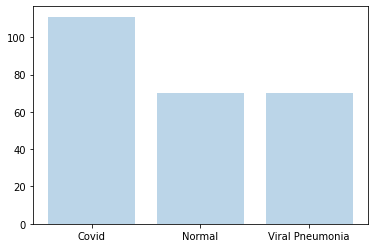

In [74]:
def describe_dataset(data):
    classes_count = { c:0 for c in classes}
    for _,label in data:
        classes_count[classes[label]]+=1

    print(f'Classes: {len(classes)} - {classes} ')
    print(f'Examples: {len(data)}')
    print(f'Counts: {classes_count}')
    plt.bar(classes_count.keys(),classes_count.values(), alpha=0.3 )

    return classes_count

_ = describe_dataset(train_ds)


TRAIN DATASET
Classes: 3 - ['Covid', 'Normal', 'Viral Pneumonia'] 
Examples: 221
Counts: {'Covid': 97, 'Normal': 65, 'Viral Pneumonia': 59}

VALIDATION DATASET
Classes: 3 - ['Covid', 'Normal', 'Viral Pneumonia'] 
Examples: 30
Counts: {'Covid': 14, 'Normal': 5, 'Viral Pneumonia': 11}

TEST DATASET
Classes: 3 - ['Covid', 'Normal', 'Viral Pneumonia'] 
Examples: 66
Counts: {'Covid': 26, 'Normal': 20, 'Viral Pneumonia': 20}


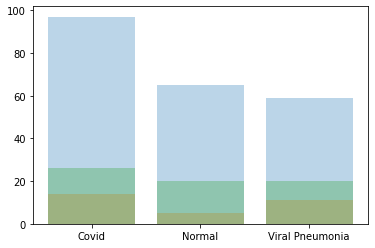

In [75]:
from torch.utils.data import random_split
random_seed = 42
torch.manual_seed(random_seed);

val_size = 30
train_size = len(train_ds) - val_size

train_ds, val_ds = random_split(train_ds, [train_size, val_size])

print("\nTRAIN DATASET")
_=describe_dataset(train_ds)

print("\nVALIDATION DATASET")
_=describe_dataset(val_ds)

print("\nTEST DATASET")
_=describe_dataset(test_ds)

dataset = None
new_dataset = None

In [76]:
batch_size = 5

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(train_loader))
print('Number of validation batches', len(valid_loader))
print('Number of test batches', len(test_loader))

Number of training batches 45
Number of validation batches 6
Number of test batches 14


# Data Visualization

In [77]:

def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{classes[int(labels[i].numpy())]}')
        plt.ylabel(f'{classes[int(preds[i].numpy())]}', color=col)
        if(i==5):
            break
    plt.tight_layout()
    plt.show()

In [78]:
images, labels = next(iter(train_loader))

In [79]:
images.shape

torch.Size([5, 3, 224, 224])

Exception ignored in: <function tqdm.__del__ at 0x0000019484998EE0>
Traceback (most recent call last):
  File "C:\Users\Naveen\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\std.py", line 1147, in __del__
    self.close()
  File "C:\Users\Naveen\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x0000019484998EE0>
Traceback (most recent call last):
  File "C:\Users\Naveen\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\std.py", line 1147, in __del__
    self.close()
  File "C:\Users\Naveen\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


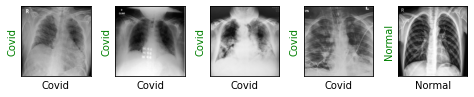

In [80]:
show_images(images, labels, labels) #passing the predicitons as the labels

In [81]:
print(train_ds[0][0].shape)
train_ds[0]

torch.Size([3, 224, 224])


(tensor([[[-1.8268, -1.8097, -1.8097,  ..., -1.7069, -1.6898, -1.7069],
          [-1.8439, -1.8268, -1.8268,  ..., -1.6898, -1.6898, -1.7240],
          [-1.8439, -1.8439, -1.8268,  ..., -1.6898, -1.6898, -1.7069],
          ...,
          [-1.7583, -1.7240, -1.7240,  ..., -1.8782, -1.8610, -1.8610],
          [-1.7754, -1.7240, -1.7240,  ..., -1.8610, -1.8782, -1.8782],
          [-1.7412, -1.7240, -1.7240,  ..., -1.8610, -1.8782, -1.8782]],
 
         [[-1.7381, -1.7206, -1.7206,  ..., -1.6155, -1.5980, -1.6155],
          [-1.7556, -1.7381, -1.7381,  ..., -1.5980, -1.5980, -1.6331],
          [-1.7556, -1.7556, -1.7381,  ..., -1.5980, -1.5980, -1.6155],
          ...,
          [-1.6681, -1.6331, -1.6331,  ..., -1.7906, -1.7731, -1.7731],
          [-1.6856, -1.6331, -1.6331,  ..., -1.7731, -1.7906, -1.7906],
          [-1.6506, -1.6331, -1.6331,  ..., -1.7731, -1.7906, -1.7906]],
 
         [[-1.5081, -1.4907, -1.4907,  ..., -1.3861, -1.3687, -1.3861],
          [-1.5256, -1.5081,

In [82]:
def show_example(img, label):
    print('Label: ', classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  Normal (1)


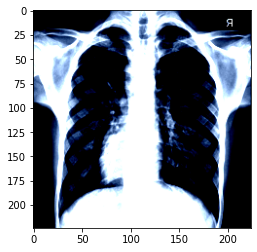

In [83]:
show_example(*train_ds[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  Viral Pneumonia (2)


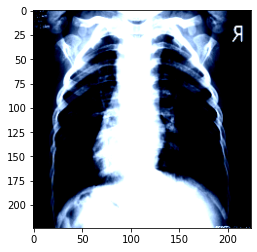

In [84]:
show_example(*train_ds[90])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


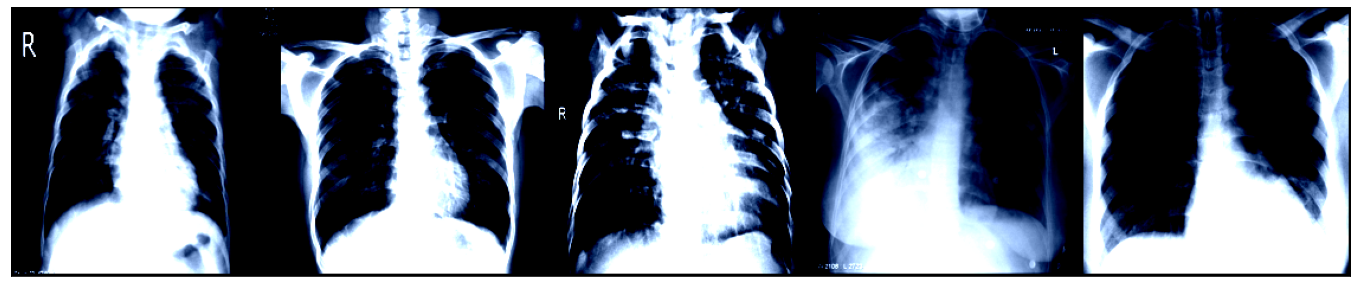

In [85]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(24, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


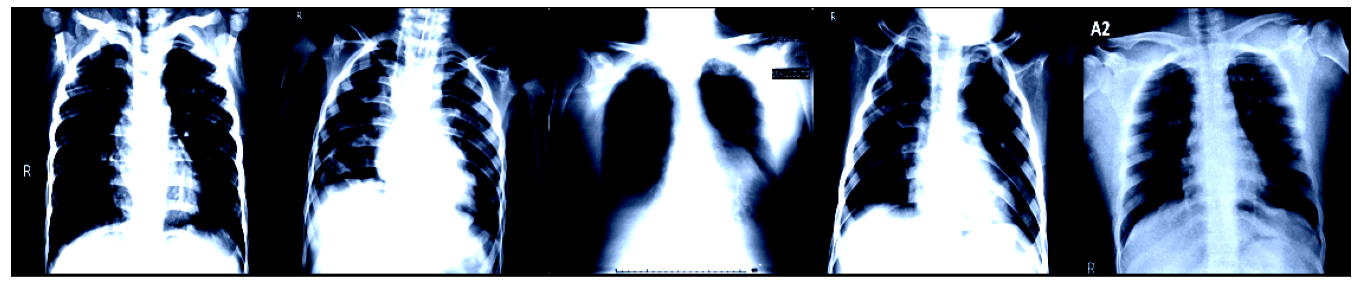

In [86]:
show_batch(test_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


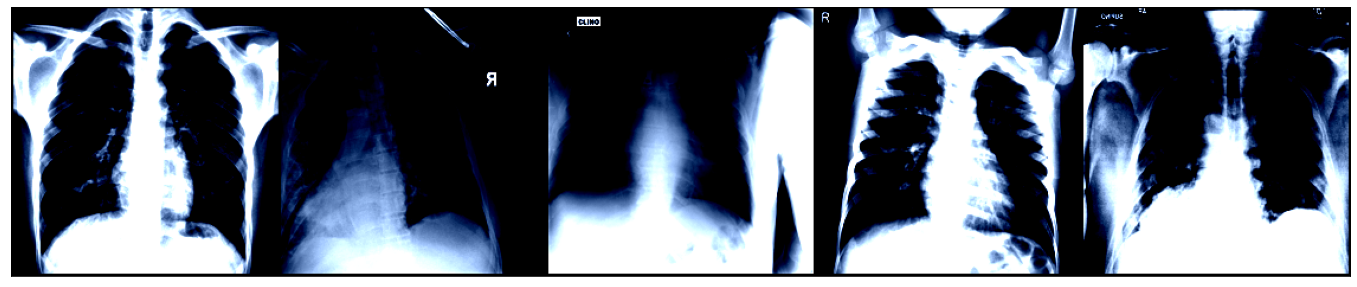

In [87]:
show_batch(valid_loader)

# Training and Evaluation functions

In [88]:
def change_device(input):
    if torch.cuda.is_available():
        return input.cuda()
    else:
        return input

In [89]:
def train(model, train_loader):
    
    model.train()
    
    epoch_loss = 0

    for train_step, (images, labels) in enumerate(train_loader):

        x_train = change_device(images)
        y_train = change_device(labels)

        optimizer.zero_grad()
        
        y_pred = model(x_train)
        
        loss = loss_fn(y_pred,y_train)
        
        loss.backward()
        
        optimizer.step()

        if(train_step%20==0):
            print(f"batch:   {train_step}   train_loss   {loss.item()}   perplexity   = {torch.exp(loss)}")
        
        epoch_loss += loss.item()
        
    return epoch_loss / (train_step +1 )

In [90]:
def evaluate(model, loader):
    
    model.eval()
    print("validation/test set evaluation")
    epoch_loss = 0
    
    with torch.no_grad():
        accuracy = 0
        for val_step, (images, labels) in enumerate(loader):
            x_train = change_device(images)
            y_train = change_device(labels)

            y_pred = model(x_train)

            loss = loss_fn(y_pred,y_train)

            _, preds = torch.max(y_pred, 1)
            accuracy += sum(( preds.cpu() == labels).numpy())

            if(val_step%3==0):
                print(f"batch:   {val_step}   validation_loss   {loss.item()}   perplexity   = {torch.exp(loss)}")
        
            epoch_loss += loss.item()
        accuracy = accuracy/len(val_ds)
        print(f' Accuracy: {accuracy:.4f}')

    return epoch_loss / (val_step + 1)

In [91]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [92]:
def show_preds(model,loader):
    model.eval() 
    print("test set evaluation")

    with torch.no_grad():
        accuracy = 0
        for test_step, (images, labels) in enumerate(loader):
            x_train = change_device(images)
            y_train = change_device(labels)

            y_pred = model(x_train)

            loss = loss_fn(y_pred,y_train)

            _, preds = torch.max(y_pred, 1)
          
            accuracy += sum(( preds.cpu() == labels).numpy())
        accuracy = accuracy/len(test_ds)
        print(f' Accuracy: {accuracy:.4f}')

    show_images(images, labels, preds.cpu())

# Simple implementation of VGG


In [93]:
class VGGNet(nn.Module):
    def __init__ (self):
        super(VGGNet,self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,padding=1,stride=1) #224
        self.maxPool1 = nn.MaxPool2d(2,2)

        self.conv2 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1,stride=1) #112
        self.maxPool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1,stride=1) #56
        self.maxPool3 = nn.MaxPool2d(2,2)

        self.conv4 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,padding=1,stride=1) #28
        self.maxPool4 = nn.MaxPool2d(2,2)

        self.conv5 = nn.Conv2d(in_channels=512,out_channels=512,kernel_size=1,padding=0,stride=1)
        self.maxPool5 = nn.MaxPool2d(2,2)

        self.conv6 = nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1,stride=1) #14
        self.maxPool6 = nn.MaxPool2d(2,2)

        self.fc1 = nn.Linear(4608,1024) #7
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512,3)

    def forward(self , x):
               
        x = self.maxPool1(F.relu(self.conv1(x)))

        x = self.maxPool2(F.relu(self.conv2(x)))

        x = self.maxPool3(F.relu(self.conv3(x)))

        x = self.maxPool4(F.relu(self.conv4(x)))

        x = self.maxPool5(F.relu(self.conv5(x)))

        x = self.maxPool6(F.relu(self.conv6(x)))

        x = x.reshape(x.shape[0], -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        return x


In [94]:
model = change_device(VGGNet())

In [95]:
model

VGGNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxPool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxPool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxPool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxPool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
  (maxPool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxPool6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (f

In [96]:
for param in model.parameters():
    print(f' {param.size()} parameters are {param.numel()}')

 torch.Size([64, 3, 3, 3]) parameters are 1728
 torch.Size([64]) parameters are 64
 torch.Size([128, 64, 3, 3]) parameters are 73728
 torch.Size([128]) parameters are 128
 torch.Size([256, 128, 3, 3]) parameters are 294912
 torch.Size([256]) parameters are 256
 torch.Size([512, 256, 3, 3]) parameters are 1179648
 torch.Size([512]) parameters are 512
 torch.Size([512, 512, 1, 1]) parameters are 262144
 torch.Size([512]) parameters are 512
 torch.Size([512, 512, 3, 3]) parameters are 2359296
 torch.Size([512]) parameters are 512
 torch.Size([1024, 4608]) parameters are 4718592
 torch.Size([1024]) parameters are 1024
 torch.Size([512, 1024]) parameters are 524288
 torch.Size([512]) parameters are 512
 torch.Size([3, 512]) parameters are 1536
 torch.Size([3]) parameters are 3


In [97]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters and total memory usage is {count_parameters(model)*(4/(2**20)*3)} mb')

The model has 9,419,395 trainable parameters and total memory usage is 107.79642105102539 mb


Training and testing

Learning Rate = 3e-5; 
Epoch = 1

In [98]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

In [99]:
N_EPOCHS = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader)
    valid_loss = evaluate(model, valid_loader)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        print("saving the model")
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_2.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

batch:   0   train_loss   1.0941715240478516   perplexity   = 2.9867072105407715
batch:   20   train_loss   1.0990883111953735   perplexity   = 3.0014283657073975
batch:   40   train_loss   1.1033796072006226   perplexity   = 3.014336109161377
validation/test set evaluation
batch:   0   validation_loss   1.0952149629592896   perplexity   = 2.9898252487182617
batch:   3   validation_loss   1.0792638063430786   perplexity   = 2.9425125122070312
 Accuracy: 0.7333
saving the model
Epoch: 01 | Time: 1m 3s
	Train Loss: 1.098 | Train PPL:   2.997
	 Val. Loss: 1.088 |  Val. PPL:   2.968


In [100]:
model.load_state_dict(torch.load('model_2.pt'))

<All keys matched successfully>

test set evaluation
 Accuracy: 0.5152


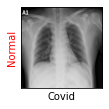

In [101]:
show_preds(model, test_loader) #learning rate 3e-5

Hence testing out the various learning rates I felt that a learning rate of 3e-5 showed significant improvement hence decided to use that for the rest of the models

# Simple Implementation of Resnet Neural Network

In [102]:
class two_layer_Block(nn.Module):
    def __init__(self, num_layers, in_channels,intermediate_channels, identity_downsample=None, stride=1):
        super(two_layer_Block, self).__init__()

        self.num_layers = num_layers
        self.expansion = 1

        self.conv1 = nn.Conv2d(in_channels,intermediate_channels,kernel_size=3, padding = 1, stride=1)

        self.bn1 = nn.BatchNorm2d(intermediate_channels)

        self.conv2 = nn.Conv2d(intermediate_channels,intermediate_channels,kernel_size=3, padding=1, stride= stride)

        self.bn2 = nn.BatchNorm2d(intermediate_channels)

        self.relu = nn.ReLU()

        self.identity_downsample = identity_downsample
      
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

class three_layer_Block(nn.Module):
    def __init__(self, num_layers, in_channels,intermediate_channels, identity_downsample=None, stride=1):
        super(three_layer_Block, self).__init__()
        self.num_layers = num_layers
        self.expansion = 4

        self.conv1 = nn.Conv2d(in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0)

        self.bn1 = nn.BatchNorm2d(intermediate_channels)

        self.conv2 = nn.Conv2d(intermediate_channels,intermediate_channels,kernel_size=3,stride=stride,padding=1)

        self.bn2 = nn.BatchNorm2d(intermediate_channels)

        self.conv3 = nn.Conv2d(intermediate_channels,intermediate_channels * self.expansion,kernel_size=1,stride=1,padding=0)

        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)

        self.relu = nn.ReLU()

        self.identity_downsample = identity_downsample

        self.stride = stride
      
    def forward(self, x):

        identity = x.clone()
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

class ResNet(nn.Module):
    def __init__(self,  num_layers, Block, img_channels, num_classes):
        super(ResNet, self).__init__()
        self.expansion = 4

        if ( num_layers< 50):
            self.expansion = 1

        if (num_layers==18):
            layers = [2,2,2,2]
      
        elif (num_layers==34):
            layers = [3,4,6,3]
        
        elif (num_layers == 50):
            layers = [3,4,6,3]
        elif (num_layers==101):
            layers = [3,4,23,3]
        elif (num_layers==152):
            layers = [3,8,36,3]

        print(layers)
        self.in_channels = 64
        self.conv1 = nn.Conv2d(in_channels=img_channels, out_channels=64, kernel_size=7, padding=3, stride=2)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        self.layer1 = self.make_layer(num_layers, Block, layers[0],intermediate_channels = 64,stride=1)
        self.layer2 = self.make_layer(num_layers, Block, layers[1],intermediate_channels = 128,stride=2)
        self.layer3 = self.make_layer(num_layers, Block, layers[2],intermediate_channels = 256,stride=2)
        self.layer4 = self.make_layer(num_layers, Block, layers[3],intermediate_channels = 512,stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512*self.expansion, num_classes)

    def forward(self, x):

        x = self.relu(self.bn(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layer(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []
        identity_downsample = None
        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                                      nn.BatchNorm2d(intermediate_channels*self.expansion))


        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion 

        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) 

        return nn.Sequential(*layers)

def ResNet18(img_channels=3, num_classes=1000):
    return ResNet(18,two_layer_Block, img_channels, num_classes)


def ResNet34(img_channels=3, num_classes=1000):
    return ResNet(34, two_layer_Block, img_channels, num_classes)


def ResNet50(img_channels=3, num_classes=1000):
    return ResNet(50, three_layer_Block, img_channels, num_classes)


def ResNet101(img_channels=3, num_classes=1000):
    return ResNet(101,  three_layer_Block, img_channels, num_classes)


def ResNet152(img_channels=3, num_classes=1000):
    return ResNet(152,  three_layer_Block, img_channels, num_classes)


In [103]:
model = change_device(ResNet18(3,3))

[2, 2, 2, 2]


In [104]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): two_layer_Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): two_layer_Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pa

In [105]:
for param in model.parameters():
    print(f' {param.size()} parameters are {param.numel()}')

 torch.Size([64, 3, 7, 7]) parameters are 9408
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([64, 64, 3, 3]) parameters are 36864
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([64, 64, 3, 3]) parameters are 36864
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([64, 64, 1, 1]) parameters are 4096
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([64, 64, 3, 3]) parameters are 36864
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([64, 64, 3, 3]) parameters are 36864
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([128, 64, 3, 3]) parameters are 73728
 torch.Size

In [106]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters and total memory usage is {count_parameters(model)*(4/(2**20)*3)} mb')

The model has 11,187,139 trainable parameters and total memory usage is 128.0266456604004 mb


In [107]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

In [108]:
N_EPOCHS = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader)
    valid_loss = evaluate(model, valid_loader)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        print("saving the model")
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_1_resnet.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

batch:   0   train_loss   1.0592479705810547   perplexity   = 2.8842012882232666
batch:   20   train_loss   0.6090688109397888   perplexity   = 1.8387184143066406
batch:   40   train_loss   0.25497061014175415   perplexity   = 1.2904237508773804
validation/test set evaluation
batch:   0   validation_loss   0.2943599224090576   perplexity   = 1.3422669172286987
batch:   3   validation_loss   0.2874559462070465   perplexity   = 1.3330318927764893
 Accuracy: 0.8667
saving the model
Epoch: 01 | Time: 0m 58s
	Train Loss: 0.670 | Train PPL:   1.955
	 Val. Loss: 0.306 |  Val. PPL:   1.358


In [109]:
model.load_state_dict(torch.load('model_1_resnet.pt'))

<All keys matched successfully>

test set evaluation
 Accuracy: 0.7424


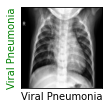

In [110]:
show_preds(model, test_loader) # using learning rate 3e-5

# Simple Implementation of Densenet Neural Network

In [112]:

class DenseNet(nn.Module):
    def __init__(self, img_channels, num_classes, num_init_features, growth_factor,layers):
        super(DenseNet,self).__init__()

        self.growth_factor = growth_factor

        self.conv1 = nn.Conv2d(in_channels=img_channels,out_channels=num_init_features,kernel_size=7,padding=3,stride=2)

        self.bn = nn.BatchNorm2d(num_init_features)

        self.relu = nn.ReLU()

        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        self.denselayer1 = self.make_layer(DenseBlock,num_init_features, layers[0])

        self.transitionlayer1 = TransitionBlock(num_init_features + self.growth_factor*layers[0])

        self.denselayer2 = self.make_layer(DenseBlock,int((num_init_features + growth_factor*layers[0])/2), layers[1])

        self.transitionlayer2 = TransitionBlock(int((num_init_features + self.growth_factor*layers[0])/2 + self.growth_factor*layers[1]))

        self.denselayer3 = self.make_layer(DenseBlock,int(((num_init_features + self.growth_factor*layers[0])/2 + self.growth_factor*layers[1])/2), layers[2])

        self.transitionlayer3 = TransitionBlock(int(((num_init_features + self.growth_factor*layers[0])/2 + self.growth_factor*layers[1])/2) + self.growth_factor*layers[2])

        self.denselayer4 = self.make_layer(DenseBlock,int((((num_init_features + self.growth_factor*layers[0])/2 + self.growth_factor*layers[1])/2 + self.growth_factor*layers[2])/2), 
                                      layers[3])

        self.averagepool = nn.AdaptiveAvgPool2d(1)

        self.fc = nn.Linear(int(num_init_features/8 + self.growth_factor*(layers[0]/8 + layers[1]/4 + layers[2]/2 + layers[3])),num_classes) #we only need to chage the output features while pre training

    def forward(self, x):
        x = self.relu(self.bn(self.conv1(x)))
        x = self.maxpool(x)
        x = self.denselayer1(x)
        x = self.transitionlayer1(x)
        x = self.denselayer2(x)
        x = self.transitionlayer2(x)
        x = self.denselayer3(x)
        x = self.transitionlayer3(x)
        x = self.denselayer4(x)
        x = self.averagepool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def make_layer(self, DenseBlock, features, layer):
        dense_block = []
        for i in range(layer):
            dense_block.append(DenseBlock(features + i*32,self.growth_factor))

        return nn.Sequential(*dense_block)

class DenseBlock(nn.Module):
    def __init__ (self,input_features, growth_factor):
        super(DenseBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(input_features)
        self.relu1 = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=input_features,out_channels=4*growth_factor,kernel_size=1,stride=1)
        self.bn2 = nn.BatchNorm2d(4*growth_factor)
        self.relu2 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=4*growth_factor,out_channels=growth_factor,kernel_size=3,stride=1,padding=1)

    def forward(self, x):
        concat_layer = x.clone()
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv1(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.conv2(x)

        return torch.cat((concat_layer, x), dim=1)



class TransitionBlock(nn.Module):
    def __init__(self, input_features):
        super(TransitionBlock,self).__init__()
        self.bn = nn.BatchNorm2d(input_features)
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=input_features,out_channels=int(input_features/2),kernel_size=1,stride=1,padding=0)
        self.avpool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv1(x)
        x = self.avpool(x)

        return x




def DenseNet121(img_channels=3, num_classes=1000,num_init_features=64,growth_factor=32):
    return DenseNet(img_channels,num_classes, num_init_features, growth_factor,[6, 12, 24, 16])

def DenseNet161(img_channels=3, num_classes=1000,num_init_features=96,growth_factor=48):
    return DenseNet(img_channels,num_classes, num_init_features, growth_factor,[6, 12, 36, 24])

def DenseNet169(img_channels=3, num_classes=1000,num_init_features=64,growth_factor=32):
    return DenseNet(img_channels,num_classes, num_init_features, growth_factor,[6, 12, 32, 32])

def DenseNet201(img_channels=3, num_classes=1000,num_init_features=64,growth_factor=32):
    return DenseNet(img_channels,num_classes, num_init_features, growth_factor,[6, 12, 48, 32])

def DenseNet264(img_channels=3, num_classes=1000,num_init_features=64,growth_factor=32):
    return DenseNet(img_channels,num_classes, num_init_features, growth_factor,[6, 12, 64, 48])

In [113]:
model = change_device(DenseNet121(3,3)) 

In [114]:
model

DenseNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (denselayer1): Sequential(
    (0): DenseBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): DenseBlock(
      (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [115]:
for param in model.parameters():
    print(f' {param.size()} parameters are {param.numel()}')

 torch.Size([64, 3, 7, 7]) parameters are 9408
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([128, 64, 1, 1]) parameters are 8192
 torch.Size([128]) parameters are 128
 torch.Size([128]) parameters are 128
 torch.Size([128]) parameters are 128
 torch.Size([32, 128, 3, 3]) parameters are 36864
 torch.Size([32]) parameters are 32
 torch.Size([96]) parameters are 96
 torch.Size([96]) parameters are 96
 torch.Size([128, 96, 1, 1]) parameters are 12288
 torch.Size([128]) parameters are 128
 torch.Size([128]) parameters are 128
 torch.Size([128]) parameters are 128
 torch.Size([32, 128, 3, 3]) parameters are 36864
 torch.Size([32]) parameters are 32
 torch.Size([128]) parameters are 128
 torch.Size([128]) parameters are 128
 torch.Size([128, 128, 1, 1]) parameters are 16384
 torch.Size([128]) parameters are 128
 torch.Size([128]) parameters are 128

In [116]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters and total memory usage is {count_parameters(model)*(4/(2**20)*3)} mb')

The model has 6,965,123 trainable parameters and total memory usage is 79.70950698852539 mb


In [117]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

In [118]:
N_EPOCHS = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader)
    valid_loss = evaluate(model, valid_loader)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        print("saving the model")
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_1_densenet.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

batch:   0   train_loss   0.9731224179267883   perplexity   = 2.6461939811706543
batch:   20   train_loss   0.8824275135993958   perplexity   = 2.4167592525482178
batch:   40   train_loss   0.6040012836456299   perplexity   = 1.829424262046814
validation/test set evaluation
batch:   0   validation_loss   0.5907468795776367   perplexity   = 1.8053362369537354
batch:   3   validation_loss   0.6430719494819641   perplexity   = 1.9023157358169556
 Accuracy: 0.6333
saving the model
Epoch: 01 | Time: 2m 25s
	Train Loss: 0.831 | Train PPL:   2.297
	 Val. Loss: 0.633 |  Val. PPL:   1.883


test set evaluation
 Accuracy: 0.6515


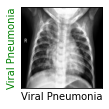

In [119]:
show_preds(model, test_loader)

# Summary and Model Results evaluation

Since denset pre trained obtained the higest results we will use that for further analysis

<h4>Data Table for the training data </H4>
The test and the validation dataset have 30 data each

In [ ]:
import plotly.figure_factory as ff

data_matrix = [['Classes','Data_available'],
               ['Normal', 70],
               ['Viral_Pneumonia', 70],
               ['Covid', 111]]

colorscale = [[0, '#4d004c'],[.5, '#f2e5ff'],[1, '#ffffff']]

fig = ff.create_table(data_matrix,colorscale=colorscale)
fig.update_layout(
    title_text = 'Data used for training',
    margin = {'t':40},
    height = 200,
    title_x=0.5
)
fig.show()

Accuracy Table

In [129]:
import plotly.figure_factory as ff

data_matrix = [['Testing paramter','Self-VGG-16', 'Self-Resnet','Self-Densenet'],
               ['Accuracy', 0.5152, 0.7424, 0.6515]]

fig = ff.create_table(data_matrix)
fig.show()